In [ ]:
from dataclasses import dataclass

import ipywidgets
import matplotlib.pyplot as plt

import pandas as pd
from IPython.display import display
from ipywidgets import Dropdown, HBox, Output, ToggleButton, VBox

pd.options.mode.chained_assignment = None

#%matplotlib inline

def load_speech_index(index_path: str, members_path: str) -> pd.DataFrame:
    """Load speech index. Merge with person index (parla. members, ministers, speakers)"""
    speech_index: pd.DataFrame = pd.read_csv(index_path, sep='\t')
    members: pd.DataFrame = pd.read_json(members_path)
    speech_index['protocol_name'] = speech_index.filename.str.split('_').str[0]
    speech_index = speech_index.merge(members, left_on='who', right_index=True, how='inner').fillna('')
    speech_index.loc[speech_index['gender']=='','gender'] = 'unknown'
    return speech_index, members

def plot_pivot(data: pd.DataFrame, kind: str):
    if kind == 'table':
        display(data)
    else:
        data.plot(kind=kind, figsize=(20,10))
        plt.show()

def compute_statistics(
    *, temporal_key: str, pivot_key: str, pivot_sub_key: str, pivot_value: str, normalize: bool, mode: str
):
    
    data: pd.DataFrame = SPEECH_INDEX.copy()

    if pivot_value:
        data = data[data[pivot_key] == pivot_value]
        pivot_key = pivot_sub_key

    if temporal_key == 'decade':
        data[temporal_key] = data.year - data.year % 10
    
    pivot: pd.DataFrame = None

    if mode == 'token':
        pivot = data.groupby([temporal_key, pivot_key]).agg({'n_tokens': sum})
    elif mode == 'speech':
        pivot = data.groupby([temporal_key, pivot_key]).size()
    elif mode == 'speaker':
        pivot = data.groupby([temporal_key, pivot_key]).agg({'who': lambda x: len(set(x))})

    if normalize:
        
        if mode == 'token':
            sums = pivot.groupby(temporal_key)['n_tokens'].sum()
        elif mode == 'speech':
            sums = pivot.sum(axis=1)
        elif mode == 'speaker':
            sums = pivot.groupby(temporal_key)['who'].sum()

    pivot = pivot.unstack(level=1).fillna(0)
    pivot = pivot.div(sums, axis=0)
    
    pivot.columns = pivot.columns.levels[1].tolist()

    return pivot

@dataclass
class CaseOneGUI:

    pivot_key: str = None
    pivot_sub_key: str = None
    pivot_values = Dropdown(description='Pivot', options=[], layout={'width': '160px'})
    mode = Dropdown(description='Mode', options=['token', 'speech', 'speaker'], value='token', layout={'width': '160px'})
    period = Dropdown(description='Period', options=['year', 'decade'], value='decade', layout={'width': '160px'})
    kind = Dropdown(description='Kind', options=['area', 'line', 'bar', 'table'], value='table', layout={'width': '160px'})
    normalize = ToggleButton(description='Normalize', value=True, layout={'width': '160px'})
    output = Output()

    def layout(self):
        return VBox([
            HBox([
                VBox([self.pivot_values, self.period]),
                VBox([self.kind, self.mode]),
                self.normalize
            ]),
            self.output
        ])

    def setup(self, pivot_values) -> "CaseOneGUI":
        self.pivot_values.options = pivot_values
        self.pivot_values.observe(self.handler, 'value')
        self.mode.observe(self.handler, 'value')
        self.period.observe(self.handler, 'value')
        self.kind.observe(self.handler, 'value')
        self.normalize.observe(self.handler, 'value')
        return self

    def update(self):

        opts: dict = dict(
            temporal_key=self.period.value,
            pivot_key=self.pivot_key,
            pivot_sub_key=self.pivot_sub_key,
            pivot_value=self.pivot_values.value,
            normalize=self.normalize.value,
            mode=self.mode.value,
        )

        self.output.clear_output()
        with self.output:
            # print(opts)
            data: pd.DataFrame = compute_statistics(**opts)
            plot_pivot(data, kind=self.kind.value)

    def handler(self, *_):
        self.update()


SPEECH_INDEX, MEMBERS = load_speech_index(
    '/data/westac/shared/document_index.csv.xz',
    '/data/westac/shared/members.json'
)
PARTYS = SPEECH_INDEX.party_abbrev.unique().tolist()
GENDERS = SPEECH_INDEX.gender.unique().tolist()


## Words/speeches per party over time
 - Ministers are encoded as party `gov` and gender `unknown`
 - Mode: `token` number of tokens, `speech` number of speeches, `speaker`number of unique speakers

In [ ]:
guip = CaseOneGUI(pivot_key='party_abbrev', pivot_sub_key='gender')\
    .setup(pivot_values=[''] + PARTYS)
display(guip.layout())
guip.update()

## Words/speeches per gender over time

In [ ]:
guig = CaseOneGUI(pivot_key='gender', pivot_sub_key='party_abbrev')\
    .setup(pivot_values=[''] + GENDERS)
display(guig.layout())
guig.update()

## Words per speech over time


<AxesSubplot:xlabel='year'>

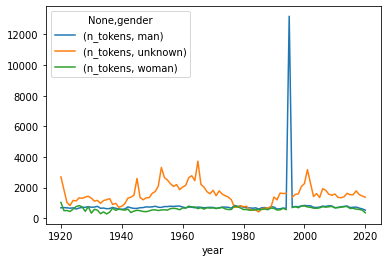

In [57]:
SPEECH_INDEX.groupby(['year', 'gender']).agg({'n_tokens': lambda x: sum(x)/len(x)}).unstack(level=1).plot()

## Missing values


# Statistik

1. Procentuell bar eller area. Normalisera efter antal ledamöter?
2. Män och kvinnor (samma bild som ovan)
3. Snitt längd av tal pedatar år, kön?


In [ ]:
dg = du.groupby(['year', 'gender']).agg({'name': lambda x: len(set(x)) }).unstack(level=1)
dg = dg.div(dg.sum(axis=1), axis=0)
dg.plot(kind='area', figsize=(20,20))

dg = du.groupby(['year', 'gender']).size().unstack(level=1)
dg = dg.div(dg.sum(axis=1), axis=0)
dg.plot(kind='area', figsize=(20,20))